<a href="https://colab.research.google.com/github/gmauricio-toledo/NLP-MCD/blob/main/13-LLM_Prompting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis using LLMs

En esta notebook realizaremos la tarea de Análisis de Sentimientos usando un LLM de la librería `transformers` de Hugging Face. Probaremos varios modelos y técnicas para hacer la tarea.

## Dataset

In [1]:
!gdown 18kGdlhOiQNS61wUK7uPbdquKL3XJrgzf

Downloading...
From: https://drive.google.com/uc?id=18kGdlhOiQNS61wUK7uPbdquKL3XJrgzf
To: /content/IMDB.csv
100% 66.2M/66.2M [00:01<00:00, 33.9MB/s]


In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

imdb_df = pd.read_csv('IMDB.csv')
display(imdb_df)

y = LabelEncoder().fit_transform(imdb_df['sentiment'].values)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(imdb_df['review'].values, y, test_size=0.2, random_state=642, stratify=y)
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X_train_raw, y_train, test_size=0.25, random_state=473, stratify=y_train)
print(f"Training set size: {len(X_train_raw)}")
print(f"Validation set size: {len(X_val_raw)}")
print(f"Test set size: {len(X_test_raw)}")

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


Training set size: 30000
Validation set size: 10000
Test set size: 10000


## Preprocesamiento

En los modelos de lenguaje modernos como BERT y sus sucesores, el preprocesamiento tradicional del texto (como la eliminación de stopwords, lematización o stemming) ya no es necesario ni recomendable.

Estos modelos están diseñados para entender el contexto y la estructura del lenguaje tal como aparece en el texto crudo, incluyendo palabras funcionales que aportan significado contextual.

Sin embargo, sí es común limpiar el texto de artefactos no lingüísticos, como etiquetas HTML, códigos de escape, URLs, o caracteres especiales irrelevantes.

En su lugar, el preprocesamiento se limita generalmente a la tokenización mediante el tokenizador específico del modelo (por ejemplo, WordPiece para BERT), la adición de tokens especiales ([CLS], [SEP]), y el relleno o truncamiento de secuencias para ajustarlas a una longitud fija.

Conservar el texto original permite al modelo aprovechar al máximo su capacidad contextual y semántica.



In [3]:
import re
import html

def clean_text(text):
    # Decodificar entidades HTML
    text = html.unescape(text)
    # Eliminar etiquetas HTML
    text = re.sub(r'<[^>]+>', ' ', text)
    # Normalizar espacios
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [4]:
train_docs = [clean_text(doc) for doc in X_train_raw]
test_docs = [clean_text(doc) for doc in X_test_raw]
val_docs = [clean_text(doc) for doc in X_val_raw]

## Sampleo

In [5]:
num_training_docs = 300
num_validation_docs = 1000

sample_train_docs, _, sample_train_labels, _ = train_test_split(train_docs, y_train,
                                                                train_size=num_training_docs,
                                                                random_state=777,
                                                                stratify=y_train)

sample_val_docs, _, sample_val_labels, _ = train_test_split(val_docs, y_val,
                                                            train_size=num_validation_docs,
                                                            random_state=777,
                                                            stratify=y_val)

## Modelo

Probemos algunos modelos:

* [Phi-3.5-mini-instruct](https://huggingface.co/microsoft/Phi-3.5-mini-instruct): Modelo de Microsoft con 3.8B parámetros, 128K tokens context length, vocabulario de 32064 tokens, entrenado en agosto/2024.
* [Qwen2.5-1.5B-Instruct](https://huggingface.co/Qwen/Qwen2.5-1.5B-Instruct): Modelo de Qwen con 1.54B parámetros, 32,768 tokens context length, Multilingual support for over 29 languages.

Observa que ahora usamos la clase Clase `AutoModelForCausalLM` de HuggingFace Transformers, es para modelos de lenguaje generativo. Carga automáticamente la arquitectura correcta según el nombre del modelo.

Tipos de tarea:
* Generación de texto
* Completación de prompts
* Chatbots
* Predicción del siguiente token

In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# model_name = "Qwen/Qwen2.5-1.5B-Instruct"
# model_name = "Qwen/Qwen-7B-Chat"
# model_name = "mosaicml/mpt-7b""
# model_name = "tiiuae/falcon-7b-instruct"
model_name = "microsoft/Phi-3.5-mini-instruct"
# model_name = "HuggingFaceH4/zephyr-7b-beta"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

Si usamos los documentos sin quitar stopwords

In [12]:
from sklearn.model_selection import train_test_split

docs, _, labels, _ = train_test_split(sample_val_docs,
                                      sample_val_labels,
                                      train_size=200,
                                      stratify=sample_val_labels,
                                      random_state=707)

## Sentiment Analysis

### Zero shot

Con GPU y 200 ejemplos, tarda alrededor de 1 minuto

In [13]:
docs[0]

'With a cast of mostly lesser-tiered stars (Alain Delon, Robert Wagner, Eddie Albert), lousy special effects (sure, it was the 70\'s but "Alien" and "Star Wars" came from the same decade), and a storyline that is so laughable that one might want to cry, this is a "flight" that should have been GROUNDED. Even Academy Award winners Cicely Tyson and George Kennedy can\'t keep this "bird" airborne. The implausibility of the third film - airplane is submerged in The Bermuda Triangle - is much more believable than this turkey. Avoid "The Concorde" at all costs!'

Haremos este [prompt](https://claude.ai/share/3b52a333-a017-4de0-9970-201b824a2b52) de forma iterada, solamente sobre un número pequeño de ejemplos

In [21]:
prompt = "Hi, what can you tell me about your self?"
messages = [
    {'role': 'system', 'content': 'You are a helpful assistant.'},
    {'role': 'user', 'content': prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=16
)
generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(response)

Hello! I'm Phi, an AI language model developed by Microsoft


In [14]:
responses = []

for k,sentence in enumerate(docs):
    prompt = "I want to perform a binary sentiment analysis task on the following text, determine if the sentiment is positive or negative. Respond only 'positive' or 'negative'. The text is: " + sentence
    messages = [
        {"role": "system", "content": "You are a helpful assistant performing binary sentiment analysis."},
        {"role": "user", "content": prompt}
    ]
    text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=16
    )
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print(f"{k+1}/{num_training_docs}")
    responses.append(response)

print(responses)

1/300
2/300
3/300
4/300
5/300
6/300
7/300
8/300
9/300
10/300
11/300
12/300
13/300
14/300
15/300
16/300
17/300
18/300
19/300
20/300
21/300
22/300
23/300
24/300
25/300
26/300
27/300
28/300
29/300
30/300
31/300
32/300
33/300
34/300
35/300
36/300
37/300
38/300
39/300
40/300
41/300
42/300
43/300
44/300
45/300
46/300
47/300
48/300
49/300
50/300
51/300
52/300
53/300
54/300
55/300
56/300
57/300
58/300
59/300
60/300
61/300
62/300
63/300
64/300
65/300
66/300
67/300
68/300
69/300
70/300
71/300
72/300
73/300
74/300
75/300
76/300
77/300
78/300
79/300
80/300
81/300
82/300
83/300
84/300
85/300
86/300
87/300
88/300
89/300
90/300
91/300
92/300
93/300
94/300
95/300
96/300
97/300
98/300
99/300
100/300
101/300
102/300
103/300
104/300
105/300
106/300
107/300
108/300
109/300
110/300
111/300
112/300
113/300
114/300
115/300
116/300
117/300
118/300
119/300
120/300
121/300
122/300
123/300
124/300
125/300
126/300
127/300
128/300
129/300
130/300
131/300
132/300
133/300
134/300
135/300
136/300
137/300
138/300
139/

### Few shot

Obtenemos unos pocos documentos de ejemplo

In [22]:
sample_docs = sample_val_docs[:3].copy()
sample_labels = sample_val_labels[:3].copy()

In [23]:
print(sample_docs)
print(sample_labels)

["The War Between the States was perhaps the darkest hour in the history of America; a war that pitted brother against brother and family against family and left scars that even today have not yet healed, and in all probability never will. And, as in any story about any war, beyond any historical significance it is the personal discord behind the greater conflict that creates the emotional impetus that makes it involving. It is the human element that renders the context necessary to give it perspective, which is what director Ang Lee provides in `Ride With the Devil,' a Civil War drama in which he focuses on the personal travails within the broader depiction of the War itself, and along the way manages to include an examination of one of the bloodiest chapters of the War, the infamous raid on Lawrence, Kansas, by Quantrill and his raiders, which he succeeds in presenting quite objectively from the Confederate point-of-view. In 1863, the Union influence predominates in the State of Kans

In [27]:
len(docs)

200

Tarda alrededor de 7 minutos

In [30]:
responses = []

label_to_text = {0: "negative", 1: "positive"}

for k, sentence in enumerate(docs):
    prompt = ""
    for label, text in zip(sample_labels[1:], sample_docs[1:]):
        prompt += f"\n{text} // {label_to_text[label]}\n"
    prompt += f"\n{sentence} // "

    messages = [
        {"role": "system", "content": "You are a helpful assistant performing binary sentiment analysis. You must respond ONLY with 'positive' or 'negative', nothing else."},
        {"role": "user", "content": prompt}
    ]

    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=3,  # Reducido ya que solo necesitamos una palabra
        num_return_sequences=1,
        do_sample=False,   # Para hacerlo más determinista
        pad_token_id=tokenizer.eos_token_id
    )

    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Limpiar la respuesta para obtener solo "positive" o "negative"
    response = response.strip().lower()
    if "positive" in response:
        response = "positive"
    elif "negative" in response:
        response = "negative"
    else:
        # Si no es claro, usar una respuesta por defecto
        response = "unknown"

    print(f"{k+1}/{len(docs)}: {response}")
    responses.append(response)

1/200: negative
2/200: positive
3/200: positive
4/200: negative
5/200: negative
6/200: negative
7/200: negative
8/200: positive
9/200: positive
10/200: negative
11/200: positive
12/200: positive
13/200: positive
14/200: positive
15/200: positive
16/200: negative
17/200: positive
18/200: negative
19/200: positive
20/200: positive
21/200: negative
22/200: positive
23/200: positive
24/200: positive
25/200: positive
26/200: negative
27/200: negative
28/200: negative
29/200: negative
30/200: positive
31/200: negative
32/200: positive
33/200: positive
34/200: negative
35/200: negative
36/200: negative
37/200: negative
38/200: positive
39/200: positive
40/200: positive
41/200: positive
42/200: negative
43/200: positive
44/200: positive
45/200: negative
46/200: positive
47/200: positive
48/200: positive
49/200: positive
50/200: positive
51/200: negative
52/200: positive
53/200: negative
54/200: positive
55/200: positive
56/200: positive
57/200: negative
58/200: negative
59/200: positive
60/200

## Evaluación

In [31]:
def encode(x):
    if x.lower() == "positive":
        return 1
    else:
        return 0

y_pred = [encode(x) for x in responses]

Zero-shot:

* Phi-3.5-mini-instruct: 94%
* Qwen2.5 1.5B: ?

Few shot:
* Phi-3.5-mini-instruct: 91%
* Qwen2.5 1.5B: ?

In [32]:
len(docs), len(labels)

(200, 200)

Accuracy: 0.91


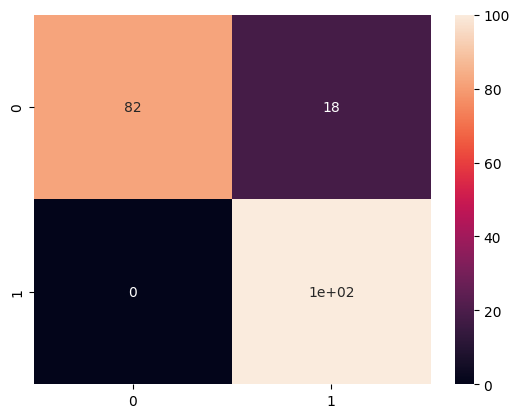

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(f"Accuracy: {accuracy_score(labels, y_pred)}")
plt.figure()
sns.heatmap(confusion_matrix(labels, y_pred), annot=True)
plt.show()

## Further Explorations

Está técnica *Dynamic Zero-Shot Categorization* podríamos usarla en más tareas:
* Topic Modeling
* Information Extraction

---

🔴 Exploraciones adicionales
* Explorar el efecto de los ejemplos para el few shot:
    * La longitud de los textos de ejemplo
    * El número de ejemplos
* Explorar más LLM.
* Explorar diferentes prompts.
* Explorar el [pipeline](https://huggingface.co/docs/transformers/main_classes/pipelines) de [*sentiment analysis*](https://huggingface.co/blog/sentiment-analysis-python) de HuggingFace, hay muchos [modelos](https://huggingface.co/models?pipeline_tag=text-classification&sort=downloads&search=sentiment) para escoger.
* Usar los embeddings generados por el modelo y aplicar algoritmos de ML.
